## Задание 

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
sales_of_company_x = pd.read_csv("../data/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("../data/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("../data/international-airline-passengers.csv")
airlines_passengers.columns = ['Month', 'Count']
mean_monthly_temp = pd.read_csv("../data/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("../data/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("../data/daily-total-female-births-in-cal.csv")

In [3]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

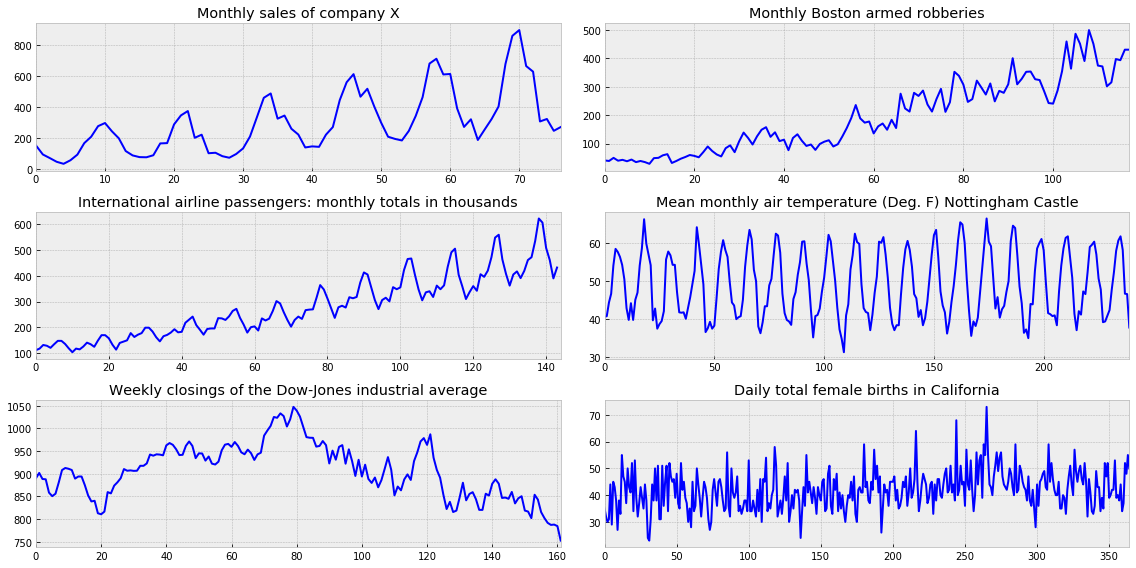

In [4]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
    plt.tight_layout()

В качестве стационарного ряда для анализа возьмем Mean monthly air temperature.   
В качестве нестационарного ряда для анализа возьмем Weekly closing the Dow-Jones industrial average.

In [5]:
# moving average
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

# weighted_moving_average
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return pd.Series([np.NaN]).append(wma, ignore_index=True)

# exponential_moving_average
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

# double_ema
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

def plot_dema(alpha, beta):
    dema = double_ema(sales_of_company_x["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(sales_of_company_x["Count"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

# holt-vinters        
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

# mse for optimizing params for holt-vinters        
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

def rmse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = np.sqrt(mean_squared_error(predictions, test))
    return error

Проанализируем стационарный временной ряд

In [6]:
series = mean_monthly_temp.Deg

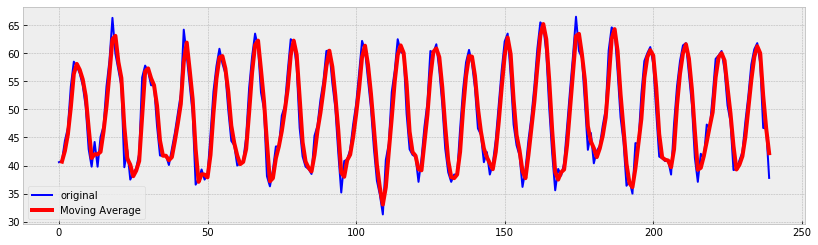

In [7]:
ser = moving_average(series, 2)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 4))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

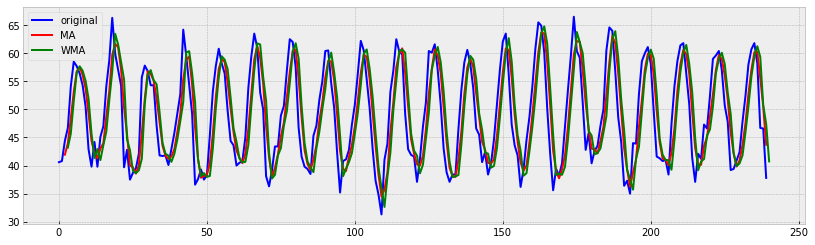

In [8]:
wma = weighted_moving_average(series, 3, [1,4,10])
ma = moving_average(series, 3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 4))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

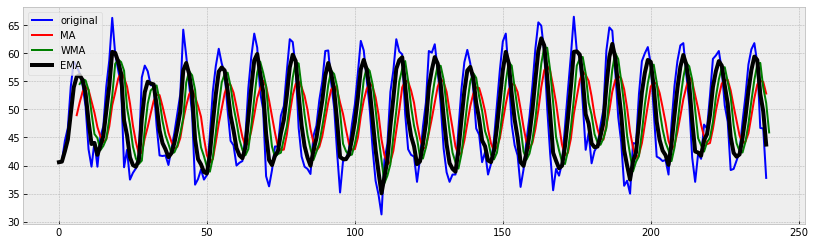

In [9]:
ema = exponential_moving_average(series, 0.5)
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 4))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [10]:
# train_test_split
train_bound = int(len(series) / 10) * 8
test_bound = int(len(series) / 10) * 9
train, test, val = series[:train_bound], series[train_bound:test_bound],series[test_bound:]
print(f'Train len : {len(train)}, test len : {len(test)}, val len : {len(val)}')

Train len : 192, test len : 24, val len : 24


      fun: 3.216075718282364
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.19904087e-06, 3.48165941e-05, 9.73695879e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 116
      nit: 23
   status: 0
  success: True
        x: array([0.34581647, 0.00439312, 0.        ])


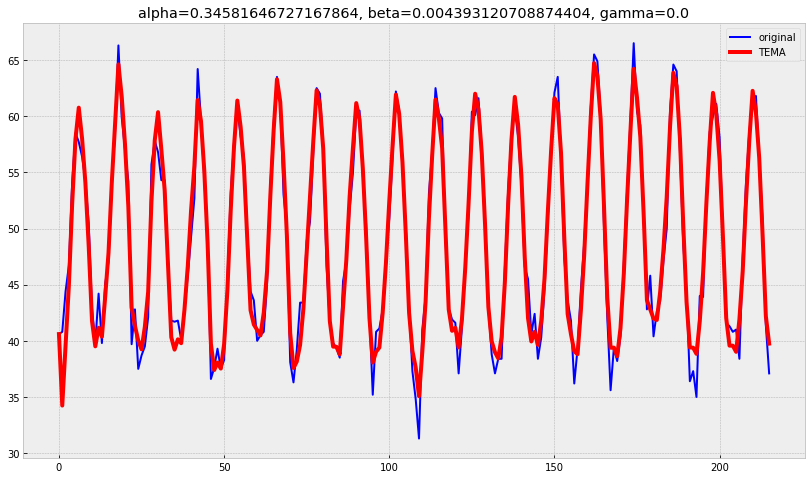

In [11]:
opt = minimize(mse, x0=[1,1,1], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:test_bound], n_preds=len(test))

Визуально скользящие средние предсказывают хорошо, более того оптимизация для Хольта-Винтерса обнулила трендовую и сезонную компоненты, оставив только уровень, и по сути стала обычной скользящей средней

Теперь проанализируем нестационарный временной ряд

In [12]:
series = dowjones_closing.Close

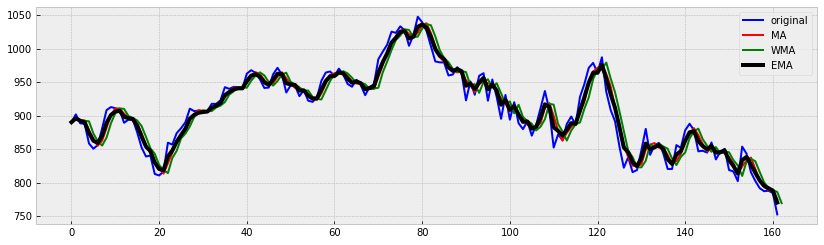

In [13]:
ema = exponential_moving_average(series, 0.5)
wma = weighted_moving_average(series, 3, [1,1,2])
ma = moving_average(series, 3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 4))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [14]:
# train_test_split
train_bound = int(len(series) / 10) * 8
test_bound = int(len(series) / 10) * 9
train, test, val = series[:train_bound], series[train_bound:test_bound],series[test_bound:]
print(f'Train len : {len(train)}, test len : {len(test)}, val len : {len(val)}')

Train len : 128, test len : 16, val len : 18


      fun: 441.4784827731248
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.17275112e-04, -4.71279043e+02, -1.13516307e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 128
      nit: 24
   status: 0
  success: True
        x: array([0.605096  , 1.        , 0.36579868])


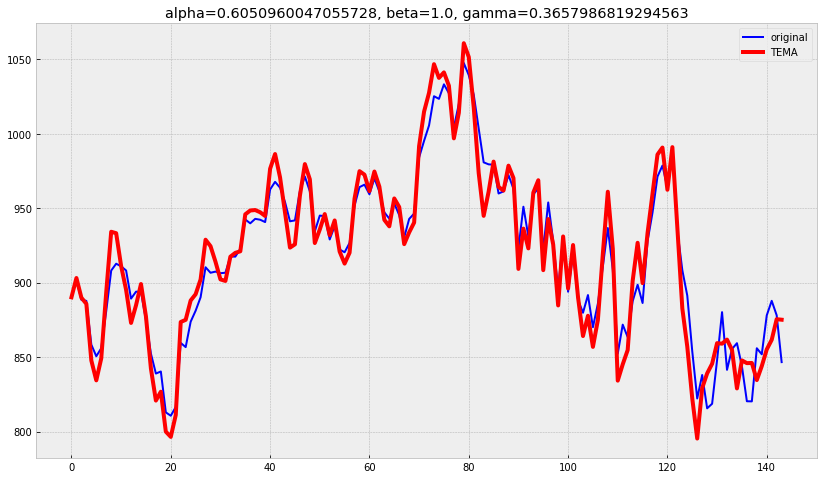

In [15]:
opt = minimize(mse, x0=[0.5,0.5,0.5], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:test_bound], n_preds=len(test))

В данном случае Хольт-Винтерс подобрал все компоненты (уровень, тренд, сезонность), значительно лучше подгоняясь под временной ряд, чем вариации скользящих средних. 